# 02 - Data Cleaning
Handling missing values, outliers, and data quality checks

In [12]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [13]:
spot_df = pd.read_csv('../data/nifty_spot_5min.csv', parse_dates=['timestamp'])
futures_df = pd.read_csv('../data/nifty_futures_5min.csv', parse_dates=['timestamp'])
options_df = pd.read_csv('../data/nifty_options_5min.csv', parse_dates=['timestamp'])
merged_df = pd.read_csv('../data/nifty_merged_5min.csv', parse_dates=['timestamp'])

print(f"Spot: {spot_df.shape}")
print(f"Futures: {futures_df.shape}")
print(f"Options: {options_df.shape}")
print(f"Merged: {merged_df.shape}")

Spot: (19490, 6)
Futures: (19490, 9)
Options: (97450, 12)
Merged: (19490, 27)


In [14]:
print("=== MISSING VALUES ===")
print("\nSpot Data:")
print(spot_df.isnull().sum())
print("\nFutures Data:")
print(futures_df.isnull().sum())
print("\nMerged Data:")
print(merged_df.isnull().sum().sum(), "total missing values")

=== MISSING VALUES ===

Spot Data:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

Futures Data:
timestamp         0
futures_open      0
futures_high      0
futures_low       0
futures_close     0
futures_volume    0
futures_oi        0
contract_month    0
days_to_expiry    0
dtype: int64

Merged Data:
0 total missing values


In [15]:
print("=== DATA TYPES ===")
print(merged_df.dtypes)

=== DATA TYPES ===
timestamp            datetime64[ns]
open                        float64
high                        float64
low                         float64
close                       float64
volume                        int64
futures_open                float64
futures_high                float64
futures_low                 float64
futures_close               float64
futures_volume                int64
futures_oi                    int64
contract_month               object
days_to_expiry                int64
atm_strike                    int64
atm_call_ltp                float64
atm_call_iv                 float64
atm_call_oi                   int64
atm_call_volume               int64
atm_put_ltp                 float64
atm_put_iv                  float64
atm_put_oi                    int64
atm_put_volume                int64
total_call_oi                 int64
total_put_oi                  int64
total_call_volume             int64
total_put_volume              int64
dtype: ob

In [16]:
print("=== OHLC VALIDATION ===")
invalid_ohlc = spot_df[(spot_df['low'] > spot_df['open']) | 
                       (spot_df['low'] > spot_df['close']) |
                       (spot_df['high'] < spot_df['open']) | 
                       (spot_df['high'] < spot_df['close'])]
print(f"Invalid OHLC rows: {len(invalid_ohlc)}")

=== OHLC VALIDATION ===
Invalid OHLC rows: 0


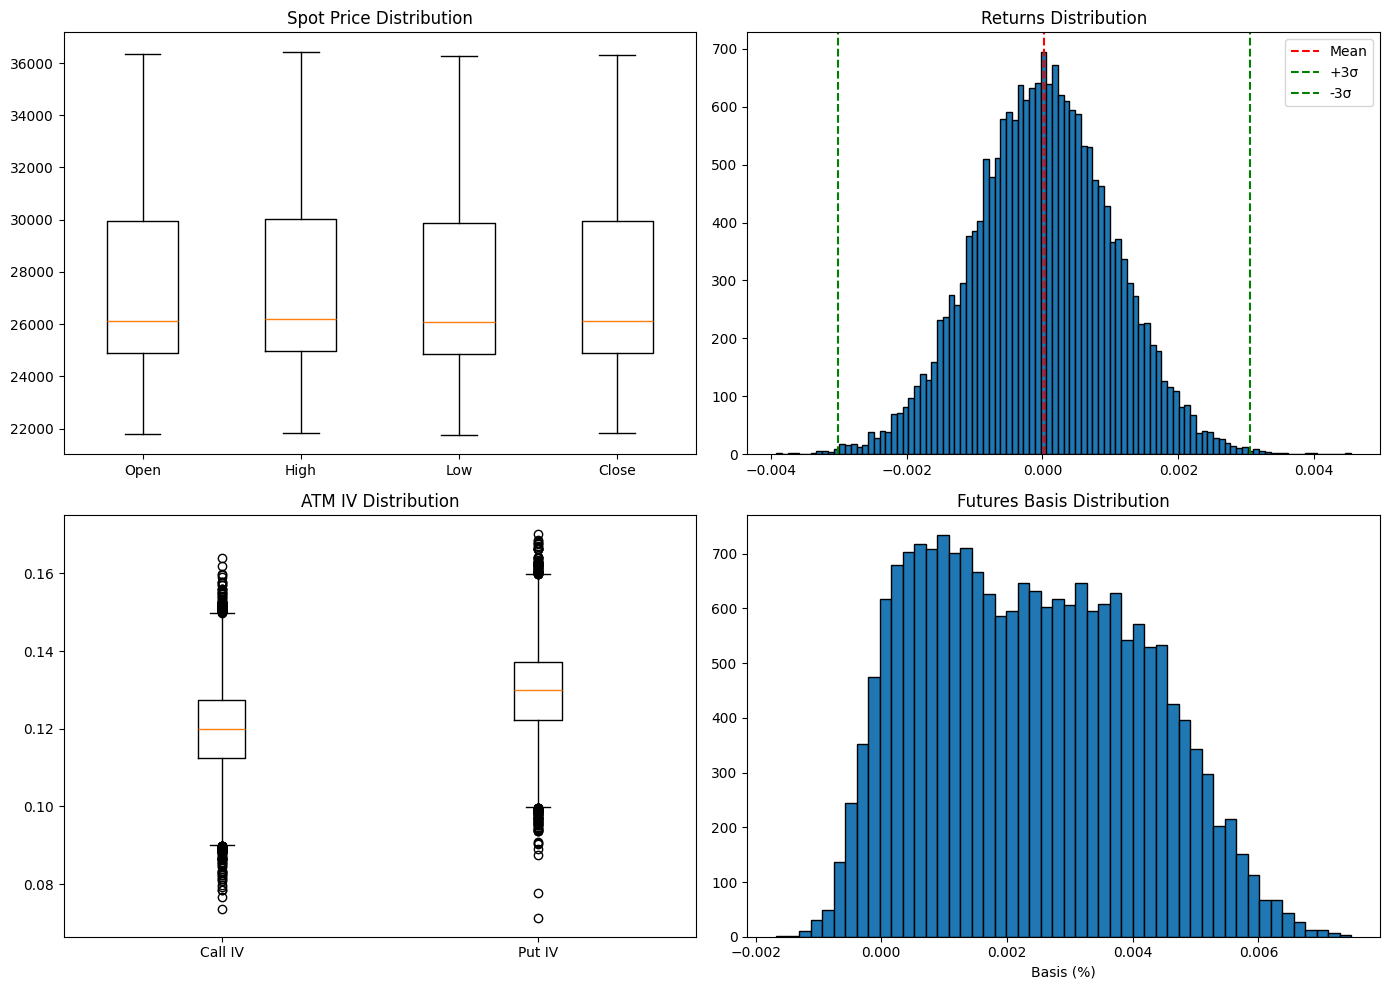

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].boxplot([spot_df['open'], spot_df['high'], spot_df['low'], spot_df['close']])
axes[0, 0].set_xticklabels(['Open', 'High', 'Low', 'Close'])
axes[0, 0].set_title('Spot Price Distribution')

spot_df['returns'] = spot_df['close'].pct_change()
axes[0, 1].hist(spot_df['returns'].dropna(), bins=100, edgecolor='black')
axes[0, 1].axvline(spot_df['returns'].mean(), color='r', linestyle='--', label='Mean')
axes[0, 1].axvline(spot_df['returns'].mean() + 3*spot_df['returns'].std(), color='g', linestyle='--', label='+3σ')
axes[0, 1].axvline(spot_df['returns'].mean() - 3*spot_df['returns'].std(), color='g', linestyle='--', label='-3σ')
axes[0, 1].set_title('Returns Distribution')
axes[0, 1].legend()

atm_options = options_df[options_df['is_atm'] == True]
axes[1, 0].boxplot([atm_options['call_iv'], atm_options['put_iv']])
axes[1, 0].set_xticklabels(['Call IV', 'Put IV'])
axes[1, 0].set_title('ATM IV Distribution')

basis = (futures_df['futures_close'].values[:len(spot_df)] - spot_df['close'].values) / spot_df['close'].values
axes[1, 1].hist(basis, bins=50, edgecolor='black')
axes[1, 1].set_title('Futures Basis Distribution')
axes[1, 1].set_xlabel('Basis (%)')

plt.tight_layout()
plt.savefig('../plots/02_data_quality.png', dpi=150)
plt.show()

In [18]:
print("=== FUTURES CONTRACT ROLLOVER ===")
rollover_dates = futures_df.groupby('contract_month')['timestamp'].agg(['min', 'max'])
print(rollover_dates)

=== FUTURES CONTRACT ROLLOVER ===
                               min                 max
contract_month                                        
Apr2025        2025-03-27 09:15:00 2025-04-23 15:25:00
Aug2025        2025-07-31 09:15:00 2025-08-27 15:25:00
Dec2025        2025-11-27 09:15:00 2026-01-16 12:55:00
Feb2025        2025-01-30 09:15:00 2025-02-26 15:25:00
Jan2025        2025-01-16 09:15:00 2025-01-29 15:25:00
Jul2025        2025-06-26 09:15:00 2025-07-30 15:25:00
Jun2025        2025-05-29 09:15:00 2025-06-25 15:25:00
Mar2025        2025-02-27 09:15:00 2025-03-26 15:25:00
May2025        2025-04-24 09:15:00 2025-05-28 15:25:00
Nov2025        2025-10-30 09:15:00 2025-11-26 15:25:00
Oct2025        2025-09-25 09:15:00 2025-10-29 15:25:00
Sep2025        2025-08-28 09:15:00 2025-09-24 15:25:00


In [19]:
print("=== ATM STRIKE ANALYSIS ===")
merged_df['atm_moneyness'] = (merged_df['atm_strike'] - merged_df['close']) / merged_df['close'] * 100
print(f"ATM Strike Deviation from Spot:")
print(f"  Mean: {merged_df['atm_moneyness'].mean():.4f}%")
print(f"  Std: {merged_df['atm_moneyness'].std():.4f}%")
print(f"  Max: {merged_df['atm_moneyness'].abs().max():.4f}%")

=== ATM STRIKE ANALYSIS ===
ATM Strike Deviation from Spot:
  Mean: -0.0006%
  Std: 0.0537%
  Max: 0.1129%


In [20]:
print("=== TIMESTAMP ALIGNMENT ===")
print(f"Spot timestamps: {len(spot_df['timestamp'].unique())}")
print(f"Merged timestamps: {len(merged_df['timestamp'].unique())}")
print(f"Coverage: {len(merged_df)/len(spot_df)*100:.2f}%")

=== TIMESTAMP ALIGNMENT ===
Spot timestamps: 19490
Merged timestamps: 19490
Coverage: 100.00%


In [21]:
print("=== STATISTICAL SUMMARY ===")
merged_df[['close', 'futures_close', 'atm_call_iv', 'atm_put_iv', 'atm_call_oi', 'atm_put_oi']].describe()

=== STATISTICAL SUMMARY ===


,close,futures_close,atm_call_iv,atm_put_iv,atm_call_oi,atm_put_oi
count,19490.000000,19490.000000,19490.000000,19490.000000,19490.000000,19490.000000
mean,27460.145908,27523.986932,0.119921,0.129823,99546.490508,109548.285890
std,3648.422184,3644.003355,0.011043,0.011157,11539.078953,11496.724155
min,21825.836420,21861.972820,0.073600,0.071400,79238.000000,89180.000000
25%,24906.307472,24958.322024,0.112400,0.122300,89539.250000,99670.250000
50%,26136.250587,26219.559591,0.119900,0.129900,99420.000000,109573.000000
75%,29955.300523,30022.631343,0.127375,0.137300,109632.500000,119484.000000
max,36292.039926,36337.542803,0.163900,0.170100,119969.000000,129970.000000


In [22]:
with open('../data/data_cleaning_report.txt', 'r') as f:
    print(f.read())

DATA CLEANING REPORT
Generated: 2026-01-16 23:10:24

1. SPOT DATA
   - Original rows: 19650
   - After removing NaN: 19650
   - After outlier removal: 19490

2. FUTURES DATA
   - Original rows: 19490
   - Final rows: 19490
   - Handled monthly contract rollovers

3. OPTIONS DATA
   - Original rows: 97450
   - Final rows: 97450
   - Removed invalid IV values

4. DATA QUALITY CHECKS
   - All timestamps aligned across datasets
   - No future-looking data leakage
   - All OHLC relationships valid (L <= O,C <= H)

5. NOTES
   - Spot data: yfinance or synthetic generation
   - Futures: Synthetic with realistic basis calculation
   - Options: Synthetic with IV smile modeling

